In [1]:
%cd /projappl/project_2006327/Detectron/datasets/2024

/projappl/project_2006327/Detectron/datasets/2024


## Train models

In [2]:
from PIL import Image

In [3]:
from detectron2.utils.logger import setup_logger
logger = setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [4]:
# Some configurations for train, val and test
from detectron2.data.datasets import register_coco_instances
#directory
name_ds = "coco_data"
name_ds_train = name_ds + "_train"
name_ds_val = name_ds + "_val"
name_ds_test = name_ds + "_test"

#images
image_root_train = name_ds + "/train"
image_root_val = name_ds + "/val"
image_root_test = name_ds + "/test"

#annotations
af = "_annotations.coco.json"
json_file_train = name_ds + "/train/" + af
json_file_val = name_ds + "/val/" + af
json_file_test = name_ds + "/test/" + af

In [5]:
# Register datasets

## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )

##validation dataset
register_coco_instances(
    name = name_ds_val,
    metadata = {},
    json_file = json_file_val,
    image_root = image_root_val
    )

## test dataset
register_coco_instances(
    name = name_ds_test,
    metadata = {},
    json_file = json_file_test,
    image_root = image_root_test
    )

### Visualize training data

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import random
random.seed(42)
import cv2
import matplotlib.pyplot as plt

def plot_random_samples(name_ds, n=3):
  # access
  ds = DatasetCatalog.get(name_ds)
  met = MetadataCatalog.get(name_ds)
  # plot (arrange in 3x3)
  nrows = int(-(-n/3)) # ceil
  ncols = 3
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
  for i,s in enumerate(random.sample(ds, n)):
    ax = axs[i//ncols][i%ncols] if len(axs.shape) == 2 else axs[i]
    img = cv2.imread(s["file_name"])
    v = Visualizer(img[:,:, ::-1], metadata=met, scale=0.5)
    v = v.draw_dataset_dict(s)
    ax.imshow(v.get_image())
    ax.axis("off")
  plt.tight_layout()
  plt.show()

[02/05 14:22:42 d2.data.datasets.coco]: Loaded 6417 images in COCO format from coco_data/train/_annotations.coco.json


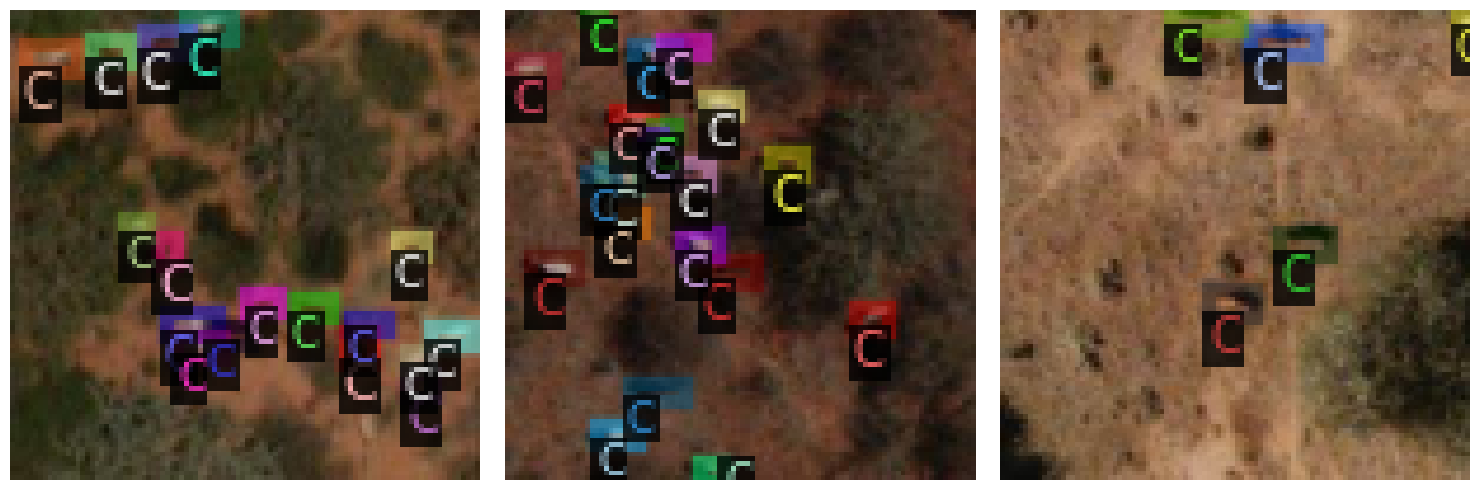

In [7]:
plot_random_samples(name_ds_train, n = 3)

[02/05 14:22:49 d2.data.datasets.coco]: Loaded 1604 images in COCO format from coco_data/val/_annotations.coco.json


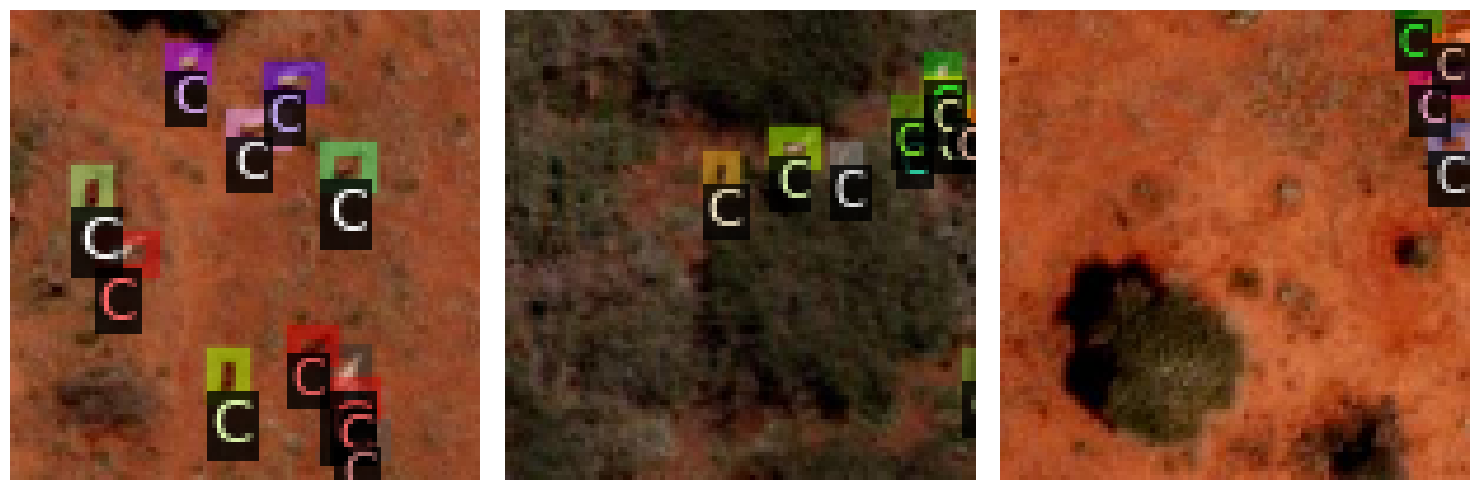

In [8]:
plot_random_samples(name_ds_val, n = 3)

[02/05 14:22:50 d2.data.datasets.coco]: Loaded 277 images in COCO format from coco_data/test/_annotations.coco.json


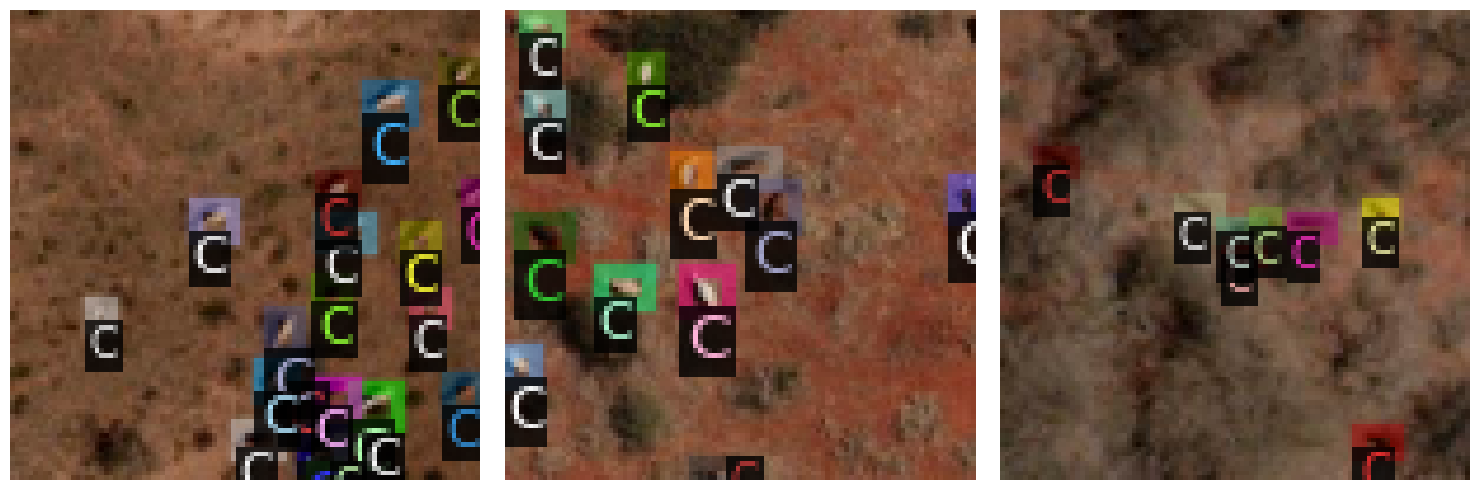

In [9]:
plot_random_samples(name_ds_test, n = 3)

### Training configuration

In [10]:
import os
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle #important for inference

In [11]:
output_dir = "output/faster_rcnn_object_detector_hook"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")
nc = 1
device = "cuda"
# Select a model
config_file_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [12]:
# Create a configuration file
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)

# Download weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)

# Set datasets
cfg.DATASETS.TRAIN = (name_ds_train,)
cfg.DATASETS.TEST = (name_ds_val,)

# Workers
cfg.DATALOADER.NUM_WORKERS = 2

# set the size of the input images
cfg.INPUT.MIN_SIZE_TRAIN = (640,)
cfg.INPUT.MAX_SIZE_TRAIN = 640

# Solver
cfg.SOLVER.IMS_PER_BATCH = 6
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 200
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.STEPS = (1000, 1500) #change
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.NESTROV = False
cfg.SOLVER.MAX_ITER = 10000 #change
cfg.SOLVER.IMS_PER_BATCH = 6

# Iterations
cfg.SOLVER.CHECKPOINT_PERIOD = 2500 #change this

# anchors
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[43.48403622, 29.42209169, 36.92428582, 52.30700844, 22.32369148]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.56776786, 1.60585184, 0.95999676]]
# pixels means and standard deviations
cfg.MODEL.PIXEL_MEAN = [ 43.5997,  66.6202, 108.2177]
cfg.MODEL.PIXEL_STD = [21.9314, 26.4536, 38.3975]

# Evaluation after every iteration as ststed in solver.checkpoint period
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD

# Classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc
cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = output_dir

In [13]:
# save configuration file for future use
with open(output_cfg_path, "wb") as f:
  pickle.dump(cfg, f, protocol = pickle.HIGHEST_PROTOCOL)

### Training

In [14]:
#Evaluation metrics created by COCO
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
class LumoTrainer(DefaultTrainer):
  """
  This trainer evaluate data on the `cfg.DATASETS.TEST` validation dataset every `cfg.TEST.EVAL_PERIOD` iterations.
  """
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder == None:
      output_folder = cfg.OUTPUT_DIR
    else:
      output_folder = os.path.join(cfg.OUTPUT_DIR, output_folder)
      os.makedirs(output_folder)
    # Use 
    return COCOEvaluator(dataset_name, distributed=False, output_dir=output_folder)


A **hook** allows developer to execute tasks on four events by overiding teh following methods.
*  before_training() to include taks to be executed before teh first training iteration
*  after_training() to include taks to be executed after training completes
*  before_step() to include taks to be executed before each training iteration
*  after_step() to include taks to be executed after each training iteration

In [15]:
#hook that read the evalution metrics from custom trainer, keep track of 
#the best model with the highest mAP@0.5 value and saves the model as model_best.pth
from detectron2.engine.hooks import HookBase
import torch
import logging

class BestModelHook(HookBase):
  def __init__(self, cfg, metric="bbox/AP50", min_max="max"):
    self._period = cfg.TEST.EVAL_PERIOD
    self.metric = metric
    self.min_max = min_max
    self.best_value = float("-inf") if min_max == "max" else float("inf")
    logger = logging.getLogger("detectron2")
    logger.setLevel(logging.DEBUG)
    logger.propagate = False
    self._logger = logger
        

  def _take_latest_metrics(self): #to achieve all evaluation metrics stored during training 
    with torch.no_grad():
      latest_metrics = self.trainer.storage.latest()
      return latest_metrics
      
  def after_step(self): #loops thro all eval metrics and gets the monitoring value
    next_iter = self.trainer.iter + 1
    is_final = next_iter == self.trainer.max_iter
    if is_final or (self._period > 0 and next_iter % self._period == 0):
      latest_metrics = self._take_latest_metrics()
      for (key, (value, iter)) in latest_metrics.items():
        if key == self.metric:
          if (self.min_max == "min" and value < self.best_value) or (self.min_max == "max" and value > self.best_value):
            self._logger.info("Updating best model at iteration {} with {} = {}".format(iter, self.metric, value))
            self.best_value = value
            self.trainer.checkpointer.save("model_best")
#saves the training model if it has better evlaution result than the current best one            

In [16]:
import gc
gc.collect()

30024

In [17]:
#utilizes the custom trainer and the hook to perform model evalution and selection during training
trainer = LumoTrainer(cfg)
bm_hook = BestModelHook(cfg, metric="bbox/AP50", min_max="max")
trainer.register_hooks(hooks=[bm_hook])
trainer.train()

[02/05 14:26:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/05 14:26:53 d2.utils.events]:  eta: 0:50:25  iter: 19  total_loss: 4.327  loss_cls: 2.294  loss_box_reg: 0.03538  loss_rpn_cls: 0.7336  loss_rpn_loc: 0.8965    time: 0.3162  last_time: 0.2841  data_time: 0.0735  last_data_time: 0.0262   lr: 9.5905e-05  max_mem: 2959M
[02/05 14:26:59 d2.utils.events]:  eta: 0:49:20  iter: 39  total_loss: 1.183  loss_cls: 0.1991  loss_box_reg: 0.09876  loss_rpn_cls: 0.6623  loss_rpn_loc: 0.2052    time: 0.3214  last_time: 0.2844  data_time: 0.0646  last_data_time: 0.0182   lr: 0.0001958  max_mem: 2959M
[02/05 14:27:06 d2.utils.events]:  eta: 0:48:48  iter: 59  total_loss: 1.087  loss_cls: 0.1544  loss_box_reg: 0.1284  loss_rpn_cls: 0.6507  loss_rpn_loc: 0.1493    time: 0.3299  last_time: 0.2762  data_time: 0.0883  last_data_time: 0.0215   lr: 0.00029571  max_mem: 2960M
[02/05 14:27:13 d2.utils.events]:  eta: 0:47:50  iter: 79  total_loss: 1.188  loss_cls: 0.2177  loss_box_reg: 0.2183  loss_rpn_cls: 0.6341  loss_rpn_loc: 0.1259    time: 0.3291  last_t

## Inference on the test dataset

In [18]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("coco_data_test", cfg, False, output_dir="./output/faster_rcnn_25/metrics")
val_loader = build_detection_test_loader(cfg, "coco_data_test")
inference_on_dataset(predictor.model, val_loader, evaluator)

[02/05 15:28:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/faster_rcnn_object_detector_hook/model_best.pth ...
WARNING [02/05 15:28:11 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/05 15:28:12 d2.data.datasets.coco]: Loaded 277 images in COCO format from coco_data/test/_annotations.coco.json
[02/05 15:28:12 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|     C      | 2642         |
|            |              |
[02/05 15:28:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/05 15:28:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/05 15:28:12 d2.data.common]: Serializing 277 elements to byte 

OrderedDict([('bbox',
              {'AP': 15.714809141782608,
               'AP50': 51.25825972334782,
               'AP75': 3.94646460994311,
               'APs': 15.714809141782608,
               'APm': nan,
               'APl': nan})])

### Get precision and recall metrics

In [19]:
#test evaluation
from detectron2.engine import DefaultPredictor
import os
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("coco_data_test", cfg, False, output_dir="./output/faster_rcnn_25/metrics")
val_loader = build_detection_test_loader(cfg, "coco_data_test")
inference_on_dataset(predictor.model, val_loader, evaluator)

# Initialize evaluator to get ground truth annotations
coco_gt_evaluator = COCOEvaluator("coco_data_test", cfg, False, output_dir="./output/faster_rcnn_25/metrics")
coco_gt_loader = build_detection_test_loader(cfg, "coco_data_test")
ground_truth_results = inference_on_dataset(predictor.model, coco_gt_loader, coco_gt_evaluator)

# Get predicted instances
predictions = evaluator._results['bbox']  # Get predicted bounding box instances

# Calculate precision and recall
coco_eval_results = coco_gt_evaluator.evaluate()
precision = coco_eval_results['bbox']['AP']  # Average Precision (AP) is the precision metric
recall = coco_eval_results['bbox']['AR']  # Average Recall (AR) is the recall metric

print("Precision:", precision)
print("Recall:", recall)

[02/05 15:28:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/faster_rcnn_object_detector_hook/model_best.pth ...
WARNING [02/05 15:28:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/05 15:28:43 d2.data.datasets.coco]: Loaded 277 images in COCO format from coco_data/test/_annotations.coco.json
[02/05 15:28:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/05 15:28:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/05 15:28:43 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/05 15:28:43 d2.data.common]: Serialized dataset takes 0.22 MiB
[02/05 15:28:43 d2.evaluation.evaluator]: Start inference on 277 batches
[02/05 15:28:44 d2.eval

AssertionError: A prediction has class=1, but the dataset only has 1 classes and predicted class id should be in [0, 0].

### Get the total cattle counts that were detected by the object detector

In [20]:
#get the number of cattle detected by the trained model

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
import os

# Load the configuration and model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25 #very high cuts off most of the predictions
predictor = DefaultPredictor(cfg)

# Create a custom evaluator to keep track of the number of detections
class CustomCOCOEvaluator(COCOEvaluator):
    def __init__(self, dataset_name, cfg, distributed, output_dir=None):
        super().__init__(dataset_name, cfg, distributed, output_dir)
        self.num_detections = 0

    def process(self, inputs, outputs):
        for output in outputs:
            num_detections = len(output["instances"])
            self.num_detections += num_detections

# Initialize the custom evaluator
evaluator = CustomCOCOEvaluator("coco_data_test", cfg, False, output_dir="./output/faster_rcnn_25/counts/")
val_loader = build_detection_test_loader(cfg, "coco_data_test")

inference_on_dataset(predictor.model, val_loader, evaluator)

# Get the number of detected objects
num_detected_objects = evaluator.num_detections
print("Number of detected objects:", num_detected_objects)

[02/05 15:29:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/faster_rcnn_object_detector_hook/model_best.pth ...
WARNING [02/05 15:29:25 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/05 15:29:25 d2.data.datasets.coco]: Loaded 277 images in COCO format from coco_data/test/_annotations.coco.json
[02/05 15:29:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/05 15:29:25 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/05 15:29:25 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/05 15:29:25 d2.data.common]: Serialized dataset takes 0.22 MiB
[02/05 15:29:25 d2.evaluation.evaluator]: Start inference on 277 batches
[02/05 15:29:26 d2.eval

### Get the number of cattle detected per image in the test patches

In [21]:
import pandas as pd

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
import os

# Load the configuration and model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25  # very high cuts off most of the predictions
predictor = DefaultPredictor(cfg)

# Create a custom evaluator to keep track of the number of detections and corresponding filenames
class CustomCOCOEvaluator(COCOEvaluator):
    def __init__(self, dataset_name, cfg, distributed, output_dir=None):
        super().__init__(dataset_name, cfg, distributed, output_dir)
        self.num_detections_per_image = []
        self.filenames = []

    def process(self, inputs, outputs):
        for input, output in zip(inputs, outputs):
            num_detections = len(output["instances"])
            self.num_detections_per_image.append(num_detections)
            self.filenames.append(os.path.basename(input["file_name"]))

# Initialize the custom evaluator
evaluator = CustomCOCOEvaluator("coco_data_test", cfg, False, output_dir="./output/faster_rcnn_25/counts/")
val_loader = build_detection_test_loader(cfg, "coco_data_test")

inference_on_dataset(predictor.model, val_loader, evaluator)

# Get the number of detected objects per image and corresponding filenames
num_detected_objects_per_image = evaluator.num_detections_per_image
filenames = evaluator.filenames

# Create a list of strings with filenames and number of detected objects
data_lines = []
for filename, num_detections in zip(filenames, num_detected_objects_per_image):
    data_lines.append(f"{filename}\t{num_detections}")

# Save the list of strings to a text file in the output folder
output_path = "./output/faster_rcnn_25/"
os.makedirs(output_path, exist_ok=True)
txt_filename = os.path.join(output_path, "detections_info.txt")
with open(txt_filename, "w") as txt_file:
    txt_file.write("\n".join(data_lines))

print("Detection information saved to:", txt_filename)

[02/05 15:29:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/faster_rcnn_object_detector_hook/model_best.pth ...
WARNING [02/05 15:29:48 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/05 15:29:48 d2.data.datasets.coco]: Loaded 277 images in COCO format from coco_data/test/_annotations.coco.json
[02/05 15:29:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/05 15:29:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/05 15:29:48 d2.data.common]: Serializing 277 elements to byte tensors and concatenating them all ...
[02/05 15:29:48 d2.data.common]: Serialized dataset takes 0.22 MiB
[02/05 15:29:48 d2.evaluation.evaluator]: Start inference on 277 batches
[02/05 15:29:49 d2.eval